# *In The Name Of God*

### *Load Dataset From Kaggle*

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [3]:
api_token = {"username":"mpyahyazadeh","key":"e7185a8edfd31216e4aa7f59e82701cb"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d jehanbhathena/weather-dataset

Dataset URL: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset
License(s): CC0-1.0


In [5]:
!unzip /content/weather-dataset.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/dataset/frost/3914.jpg  
  inflating: data/dataset/frost/3915.jpg  
  inflating: data/dataset/frost/3916.jpg  
  inflating: data/dataset/frost/3917.jpg  
  inflating: data/dataset/frost/3918.jpg  
  inflating: data/dataset/frost/3919.jpg  
  inflating: data/dataset/frost/3920.jpg  
  inflating: data/dataset/frost/3921.jpg  
  inflating: data/dataset/frost/3922.jpg  
  inflating: data/dataset/frost/3923.jpg  
  inflating: data/dataset/frost/3924.jpg  
  inflating: data/dataset/frost/3925.jpg  
  inflating: data/dataset/frost/3926.jpg  
  inflating: data/dataset/frost/3927.jpg  
  inflating: data/dataset/frost/3928.jpg  
  inflating: data/dataset/frost/3929.jpg  
  inflating: data/dataset/frost/3930.jpg  
  inflating: data/dataset/frost/3931.jpg  
  inflating: data/dataset/frost/3932.jpg  
  inflating: data/dataset/frost/3933.jpg  
  inflating: data/dataset/frost/3934.jpg  
  inflating: data/dataset/frost/3935.jpg  
  i

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## *Preprocessing & Data Augmentation*

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/dataset",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/dataset",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

## *Transformer Model (Vit)*

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def build_vit_classifier(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Patch creation
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) ** 2
    projection_dim = 64
    patch_dim = patch_size * patch_size * 3

    patches = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size)(x)
    x = layers.Reshape((num_patches, projection_dim))(patches)

    # Add positional embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    x = x + pos_embedding

    # Transformer Encoder
    for _ in range(4):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attention_output, x])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=[projection_dim * 2, projection_dim], dropout_rate=0.1)
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [9]:
vit_model = build_vit_classifier(input_shape=(224, 224, 3), num_classes=num_classes)
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = vit_model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.2366 - loss: 2.2746 - val_accuracy: 0.3812 - val_loss: 1.7899
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 39s 117ms/step - accuracy: 0.3735 - loss: 1.8233 - val_accuracy: 0.3688 - val_loss: 1.7763
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.3999 - loss: 1.7209 - val_accuracy: 0.4337 - val_loss: 1.6502
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.4354 - loss: 1.6352 - val_accuracy: 0.4949 - val_loss: 1.5568
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.4689 - loss: 1.5169 - val_accuracy: 0.5168 - val_loss: 1.4161
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.5127 - loss: 1.4025 - val_accuracy: 0.5547 - val_loss: 1.3467
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.5455 - loss: 1.2947 - val_accuracy: 0.5569 - val_loss: 1.3159
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.5620 - loss: 1

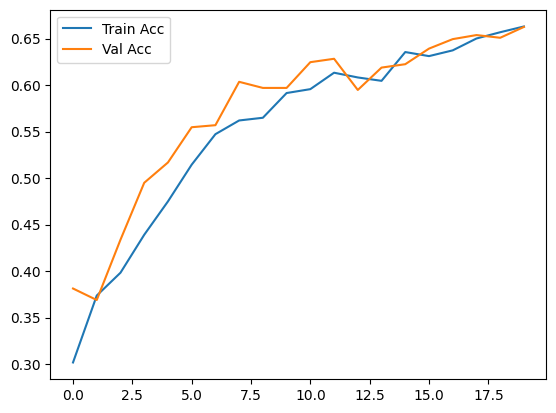

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━

In [10]:
# Plotting training history
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

# Classification Report
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = vit_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

In [23]:
# Evaluate the model
vit_eval = vit_model.evaluate(val_ds)
print(f"vit Accuracy: {vit_eval[1]:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6525 - loss: 1.0698
vit Accuracy: 0.6625


## *Cnn Model (pretrain-resnet50)*

In [12]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define your input shape and number of classes
IMG_SIZE = (224, 224)
NUM_CLASSES = len(class_names)  # you already defined class_names in ViT model

# Build CNN model using pretrained ResNet50
def build_cnn_model(input_shape=(224, 224, 3), num_classes=10):
    base_model = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze base model

    inputs = tf.keras.Input(shape=input_shape)
    x = preprocess_input(inputs)  # ResNet expects preprocessed input
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [13]:
# Create and compile the model
cnn_model = build_cnn_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES)
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:
# Train the model
history_cnn = cnn_model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - accuracy: 0.5788 - loss: 1.3607 - val_accuracy: 0.8586 - val_loss: 0.4215
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.8707 - loss: 0.3886 - val_accuracy: 0.8659 - val_loss: 0.3814
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.9020 - loss: 0.2792 - val_accuracy: 0.8848 - val_loss: 0.3645
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9153 - loss: 0.2455 - val_accuracy: 0.8776 - val_loss: 0.3429
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9221 - loss: 0.2221 - val_accuracy: 0.8987 - val_loss: 0.3337
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.9313 - loss: 0.1908 - val_accuracy: 0.9009 - val_loss: 0.3239
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.9480 - loss: 0.1625 - val_accuracy: 0.8870 - val_loss: 0.3424
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.9435 - loss: 0

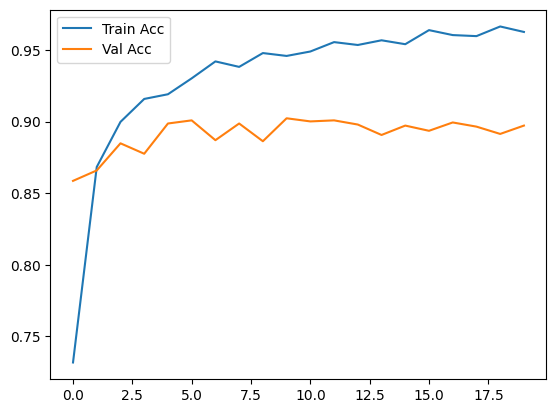

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━

In [18]:
# Plotting training history_cnn
plt.plot(history_cnn.history["accuracy"], label="Train Acc")
plt.plot(history_cnn.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

# Classification Report
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = vit_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

In [16]:
# Evaluate the model
cnn_eval = cnn_model.evaluate(val_ds)
print(f"CNN (ResNet50) Accuracy: {cnn_eval[1]:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8980 - loss: 0.3522
CNN (ResNet50) Accuracy: 0.8972


## *Compare Two Models and Save The one that is better.*

In [19]:
import matplotlib.pyplot as plt

def plot_training_histories(histories, labels):
    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['accuracy'], label=f'{label} Train')
        plt.plot(hist.history['val_accuracy'], linestyle='--', label=f'{label} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['loss'], label=f'{label} Train')
        plt.plot(hist.history['val_loss'], linestyle='--', label=f'{label} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

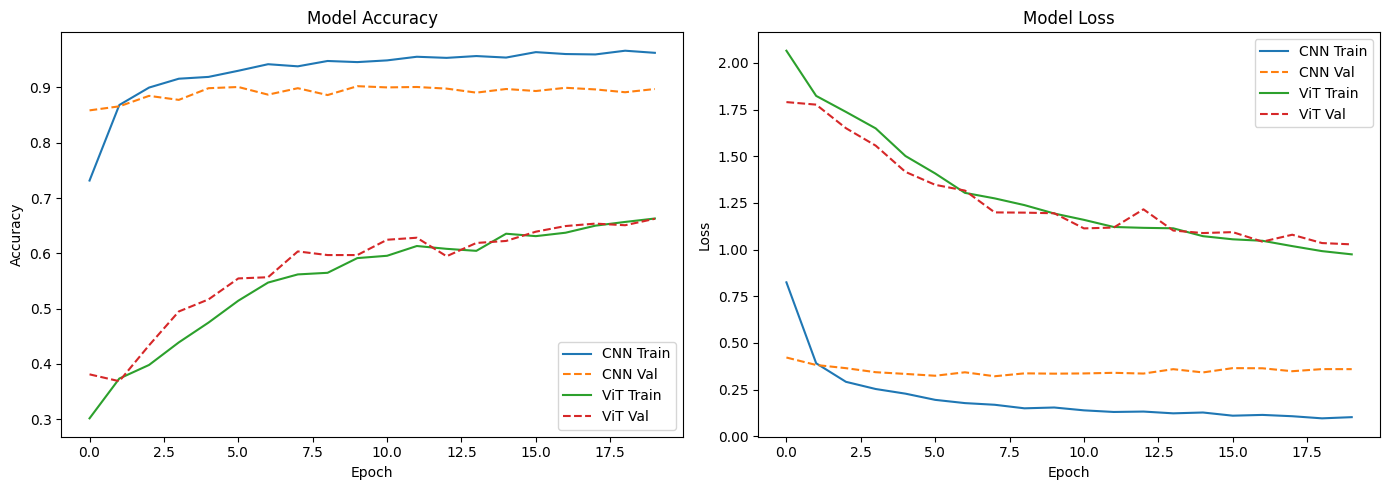

In [20]:
plot_training_histories([history_cnn, history], ['CNN', 'ViT'])

In [21]:
# Assume you already evaluated them
cnn_eval = cnn_model.evaluate(val_ds, verbose=0)
vit_eval = vit_model.evaluate(val_ds, verbose=0)

print(f"CNN Accuracy: {cnn_eval[1]:.4f}")
print(f"ViT Accuracy: {vit_eval[1]:.4f}")

# Compare and save
if cnn_eval[1] > vit_eval[1]:
    print("✅ CNN performed better. Saving CNN model.")
    cnn_model.save("best_model.h5")
else:
    print("✅ ViT performed better. Saving ViT model.")
    vit_model.save("best_model.h5")

CNN Accuracy: 0.8972
ViT Accuracy: 0.6625
✅ CNN performed better. Saving CNN model.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Function to preprocess image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale image to [0, 1]
    return img_array, img

# List of image paths (update with your actual image paths)
image_paths = [
    "/content/rain images (1).jpg",
    "/content/sun images (1).jpg",  # Add more image paths here
    "/content/lightning.jpg",
    "/content/sun.jpg"
]

# Loop through each image and display the prediction
for image_path in image_paths:
    # Preprocess the image
    input_tensor, original_image = preprocess_image(image_path)

    # Predict with the CNN model
    pred = cnn_model.predict(input_tensor)
    predicted_label = class_names[np.argmax(pred)]

    # Display the result
    plt.imshow(original_image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()


In [29]:
# Works fine for standard CNN (ResNet, MobileNet, etc.)
cnn_model.save("cnn_model.keras")  # or model.save("cnn_model") - TensorFlow recommends .keras now

In [30]:
cnn_model = tf.keras.models.load_model("/content/cnn_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# this cell for loading vit model
import tensorflow_hub as hub

vit_model = tf.keras.models.load_model(
    "vit_weather_model",
    custom_objects={"KerasLayer": hub.KerasLayer}
)

In [42]:
# Predict on a batch of validation data
val_images, val_labels = next(iter(val_ds.unbatch().batch(16)))
preds = cnn_model.predict(val_images)
y_pred = np.argmax(preds, axis=1)

# Print predicted and true labels
print("Actual:   ", [class_names[i] for i in val_labels.numpy()])
print("Predicted:", [class_names[i] for i in y_pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Actual:    ['sandstorm', 'rime', 'snow', 'dew', 'snow', 'rain', 'snow', 'rime', 'dew', 'hail', 'hail', 'rime', 'rain', 'rime', 'lightning', 'sandstorm']
Predicted: ['sandstorm', 'rime', 'glaze', 'dew', 'snow', 'rain', 'snow', 'rime', 'dew', 'hail', 'hail', 'rime', 'rain', 'rime', 'lightning', 'sandstorm']


## *Chatgpt Version In line with the model's progress (Vit Model)*

In [ ]:
# Weather Image Classification with Vision Transformer (ViT) - Improved Version

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Load dataset
data_dir = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/kaggle-data-sets/3111747/5391011/compressed/weather_dataset.zip?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential...',
    fname='weather_dataset.zip',
    extract=True)

data_root = pathlib.Path(data_dir).with_suffix('') / 'weather_dataset'
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_root,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

# Prefetch and cache
autotune = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

# Data Augmentation
augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

# Load improved ViT model from TF Hub
vit_url = "https://tfhub.dev/google/vit/large_patch16_224/1"
vit_layer = hub.KerasLayer(vit_url, trainable=True)

# Build model
inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
x = augmentation(inputs)
x = vit_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Compile model with improved settings
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=4),
    tf.keras.callbacks.ModelCheckpoint("best_vit_model.h5", save_best_only=True)
]

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks)

# Save current history for comparison
vit_history = history.history

# Save model for future use
model.save("vit_weather_model")  # Folder format
# To load: model = tf.keras.models.load_model("vit_weather_model", custom_objects={"KerasLayer": hub.KerasLayer})

# Plot results
def plot_history(histories, model_names):
    plt.figure(figsize=(12, 5))
    for history, name in zip(histories, model_names):
        plt.plot(history['val_accuracy'], label=f'{name} Val Acc')
        plt.plot(history['accuracy'], linestyle='--', label=f'{name} Train Acc')
    plt.legend()
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

# Evaluate
val_images, val_labels = next(iter(val_ds.unbatch().batch(len(val_ds))))
preds = model.predict(val_images)
y_pred = np.argmax(preds, axis=1)

print("\nClassification Report:\n")
print(classification_report(val_labels, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Save for future comparison
# Example: If you train CNN model separately, you can load and compare like below:
# from cnn_model import cnn_history
# plot_history([vit_history, cnn_history], ["ViT", "CNN"])